In [2]:
from xbbg import blp
import pandas as pd
import logging
from typing import List, Optional, Union, Dict
from datetime import datetime
from pandas.tseries.offsets import BDay

In [3]:
class BloombergDataFetcher:
  """A class to fetch and process Bloomberg data with comprehensive error handling and date alignment."""
  
  # Frequency mapping for daily and longer periods only
  FREQUENCY_MAPPING = {
      # Daily frequencies
      'D': 'DAILY',
      'DAILY': 'DAILY',
      
      # Weekly frequencies
      'W': 'WEEKLY',
      'WEEKLY': 'WEEKLY',
      
      # Monthly frequencies
      'M': 'MONTHLY',
      'MONTHLY': 'MONTHLY',
      
      # Quarterly frequencies
      'Q': 'QUARTERLY',
      'QUARTERLY': 'QUARTERLY',
      
      # Yearly frequencies
      'Y': 'YEARLY',
      'YEARLY': 'YEARLY',
      'A': 'YEARLY',
      'ANNUAL': 'YEARLY',
      
      # Semi-annual frequencies
      'SEMI': 'SEMI_ANNUALLY',
      'SEMI_ANNUAL': 'SEMI_ANNUALLY',
      'SEMI_ANNUALLY': 'SEMI_ANNUALLY',
      
      # Business day frequencies
      'B': 'BUSINESS',
      'BUS': 'BUSINESS',
      'BUSINESS': 'BUSINESS',
  }
  
  def __init__(
      self,
      tickers: Union[str, List[str]],
      fields: Union[str, List[str]],
      start_date: str,
      end_date: str,
      freq: str = 'D',
      logger: Optional[logging.Logger] = None,
      column_name_format: str = 'default'
  ):
      """Initialize Bloomberg data fetcher with comprehensive input validation."""
      self.logger = logger or self._setup_logger()
      self.tickers = [tickers] if isinstance(tickers, str) else tickers
      self.fields = [fields] if isinstance(fields, str) else fields
      self.start_date = start_date
      self.end_date = end_date
      self.freq = self._normalize_frequency(freq)
      self.column_name_format = column_name_format
      self.custom_names = None
      self._validate_inputs()
      self.fetch_attempts = 0
      self.last_error = None

  @staticmethod
  def _setup_logger() -> logging.Logger:
      """Set up and return a default logger."""
      logger = logging.getLogger('BloombergDataFetcher')
      if not logger.handlers:
          handler = logging.StreamHandler()
          formatter = logging.Formatter(
              '%(asctime)s - %(name)s - %(levelname)s - %(message)s'
          )
          handler.setFormatter(formatter)
          logger.addHandler(handler)
          logger.setLevel(logging.INFO)
      return logger

  def _normalize_frequency(self, freq: str) -> str:
      """Normalize frequency string to Bloomberg-compatible format."""
      freq_upper = freq.upper()
      if freq_upper in self.FREQUENCY_MAPPING:
          return self.FREQUENCY_MAPPING[freq_upper]
      raise ValueError(
          f"Unsupported frequency: {freq}. "
          f"Supported frequencies: {', '.join(sorted(self.FREQUENCY_MAPPING.keys()))}"
      )

  def set_custom_column_names(self, names: Dict[str, str]) -> None:
      """Set custom names for columns."""
      self.custom_names = names
      self.logger.info(f"Set custom column names: {names}")

  def _format_column_names(self, df: pd.DataFrame) -> pd.DataFrame:
      """Format column names based on specified format."""
      if df.empty:
          return df

      # First flatten MultiIndex columns if they exist
      if isinstance(df.columns, pd.MultiIndex):
          df.columns = [f"{ticker}_{field}" for ticker, field in df.columns]

      if self.column_name_format == 'custom' and self.custom_names is not None:
          # Apply custom names
          df = df.rename(columns=self.custom_names)
          # Keep original names for columns not in custom_names
          missing_columns = set(df.columns) - set(self.custom_names.values())
          if missing_columns:
              self.logger.warning(
                  f"No custom names provided for columns: {missing_columns}"
              )
      
      return df

  def _validate_inputs(self) -> None:
      """Validate input parameters."""
      if not self.tickers:
          raise ValueError("At least one ticker must be provided")
      if not self.fields:
          raise ValueError("At least one field must be provided")
      try:
          start = pd.to_datetime(self.start_date)
          end = pd.to_datetime(self.end_date)
          if start > end:
              raise ValueError("Start date must be before end date")
          if start > pd.Timestamp.now():
              raise ValueError("Start date cannot be in the future")
      except ValueError as e:
          raise ValueError(f"Invalid date format: {str(e)}")

  def fetch_data(self) -> pd.DataFrame:
      """Fetch data from Bloomberg with retry logic and error handling."""
      self.fetch_attempts += 1
      MAX_RETRIES = 3
      
      try:
          self.logger.info(
              f"Fetching data for {len(self.tickers)} tickers and {len(self.fields)} fields"
          )
          
          data = blp.bdh(
              tickers=self.tickers,
              flds=self.fields,
              start_date=self.start_date,
              end_date=self.end_date,
              Per=self.freq
          )
          
          if data.empty:
              self.logger.warning("Retrieved empty dataset")
              return pd.DataFrame()
          
          data = self._format_column_names(data)
          self.logger.info(f"Successfully retrieved {len(data)} rows of data")
          self.logger.info("\nFirst few rows:\n" + str(data.head()))
          self.logger.info("\nLast few rows:\n" + str(data.tail()))
          return data
          
      except Exception as e:
          self.last_error = str(e)
          self.logger.error(f"Error fetching data: {str(e)}")
          
          if self.fetch_attempts < MAX_RETRIES:
              self.logger.info(f"Retrying... (Attempt {self.fetch_attempts + 1}/{MAX_RETRIES})")
              return self.fetch_data()
          
          return pd.DataFrame()

  def align_dates(self, df: pd.DataFrame, calendar: str = 'business', handle_different_starts: bool = True) -> pd.DataFrame:
      """
      Align time series data to ensure consistent dates across all series.
      
      Parameters:
      -----------
      df : pd.DataFrame
          Input DataFrame
      calendar : str
          'business' for business days, 'calendar' for calendar days
      handle_different_starts : bool
          If True, handle different start dates by using the latest start date among all series
          If False, use the earliest start date and fill with NaN
      """
      if df.empty:
          return df

      df.index = pd.to_datetime(df.index)
      
      # Get first valid index for each column
      first_valid_dates = {col: df[col].first_valid_index() for col in df.columns}
      last_valid_dates = {col: df[col].last_valid_index() for col in df.columns}
      
      # Log start date differences if they exist
      start_date_differences = len(set(first_valid_dates.values())) > 1
      if start_date_differences:
          self.logger.warning("\nDifferent start dates detected:")
          for col, start_date in first_valid_dates.items():
              self.logger.warning(f"{col}: {start_date}")
      
      # Determine start and end dates
      if handle_different_starts:
          # Use latest start date and earliest end date to avoid NaN padding
          start_date = max(first_valid_dates.values())
          end_date = min(last_valid_dates.values())
          self.logger.info(f"\nUsing common date range: {start_date} to {end_date}")
      else:
          # Use full range (will include NaNs for missing periods)
          start_date = min(first_valid_dates.values())
          end_date = max(last_valid_dates.values())
          self.logger.info(f"\nUsing full date range: {start_date} to {end_date}")

      # Create date range
      date_range = pd.date_range(
          start=start_date,
          end=end_date,
          freq=BDay() if calendar == 'business' else 'D'
      )

      # Reindex the DataFrame
      aligned_df = df.reindex(date_range)
      
      self.logger.info(
          f"Date alignment: Original shape: {df.shape}, "
          f"Aligned shape: {aligned_df.shape}"
      )
      
      # Log missing values for each column after alignment
      missing_after_align = aligned_df.isna().sum()
      if missing_after_align.any():
          self.logger.info("\nMissing values after alignment:")
          for col in aligned_df.columns:
              missing_pct = (missing_after_align[col] / len(aligned_df)) * 100
              self.logger.info(f"{col}: {missing_after_align[col]} ({missing_pct:.2f}%)")
      
      return aligned_df

  def handle_missing_data(
      self,
      df: pd.DataFrame,
      method: str = 'ffill',
      max_gap: Optional[int] = None,
      align_dates: bool = True,
      calendar: str = 'business',
      handle_different_starts: bool = True
  ) -> pd.DataFrame:
      """Handle missing data and align dates."""
      if df.empty:
          return df

      if align_dates:
          df = self.align_dates(df, calendar, handle_different_starts)
          
      missing_report = self._generate_missing_report(df)
      
      if missing_report['total_missing'] > 0:
          self.logger.info(f"Found {missing_report['total_missing']} missing values")
          
          if method == 'ffill':
              df = df.ffill(limit=max_gap)
          elif method == 'bfill':
              df = df.bfill(limit=max_gap)
          elif method == 'interpolate':
              df = df.interpolate(method='time', limit=max_gap)

      return df

  def _generate_missing_report(self, df: pd.DataFrame) -> Dict:
      """Generate detailed missing data report."""
      return {
          'total_missing': df.isna().sum().sum(),
          'missing_by_column': df.isna().sum().to_dict(),
          'missing_percentage': (df.isna().sum() / len(df) * 100).to_dict()
      }

  def run_pipeline(
      self,
      handle_missing: bool = True,
      missing_method: str = 'ffill',
      max_gap: Optional[int] = None,
      align_dates: bool = True,
      calendar: str = 'business',
      handle_different_starts: bool = True
  ) -> pd.DataFrame:
      """Run the complete data fetching pipeline with date alignment."""
      df = self.fetch_data()
      
      if handle_missing or align_dates:
          df = self.handle_missing_data(
              df,
              method=missing_method,
              max_gap=max_gap,
              align_dates=align_dates,
              calendar=calendar,
              handle_different_starts=handle_different_starts
          )
      
      # Add summary at the end
      self.logger.info("\nData Summary:")
      self.logger.info(f"Shape: {df.shape}")
      self.logger.info("\nFirst few rows:\n" + str(df.head()))
      self.logger.info("\nLast few rows:\n" + str(df.tail()))
      self.logger.info("\nBasic statistics:\n" + str(df.describe()))
      
      return df

def check_alignment(df: pd.DataFrame) -> None:
  """Check if all series have the same dates."""
  print(f"Total dates: {len(df)}")
  print(f"Date range: {df.index.min()} to {df.index.max()}")
  print(f"Missing values per column:")
  print(df.isna().sum())
  print("\nMissing values percentage per column:")
  print((df.isna().sum() / len(df) * 100).round(2))



2024-10-25 14:01:04,116 - BloombergDataFetcher - INFO - Set custom column names: {'LUACTRUU Index_OAS_SOVEREIGN_CURVE': 'us_credit', 'I05510CA Index_OAS_SOVEREIGN_CURVE': 'cad_credit'}
2024-10-25 14:01:04,116 - BloombergDataFetcher - INFO - Fetching data for 2 tickers and 1 fields
2024-10-25 14:01:04,846 - BloombergDataFetcher - INFO - Successfully retrieved 4962 rows of data
2024-10-25 14:01:04,851 - BloombergDataFetcher - INFO - 
First few rows:
            us_credit  cad_credit
2005-01-20   0.830003    0.588038
2005-01-21   0.829902    0.588895
2005-01-24   0.822378    0.591135
2005-01-25   0.817361    0.588263
2005-01-26   0.808552    0.584875
2024-10-25 14:01:04,851 - BloombergDataFetcher - INFO - 
Last few rows:
            us_credit  cad_credit
2024-10-18   0.810660    1.102002
2024-10-21   0.826746    1.099407
2024-10-22   0.829744    1.106175
2024-10-23   0.834047    1.102431
2024-10-24   0.835127    1.104802
2024-10-25 14:01:04,853 - BloombergDataFetcher - INFO - 
Using commo


Data Analysis:
Total trading days: 5156

Summary Statistics:
       us_credit  cad_credit
count   5156.000    5156.000
mean       1.494       1.289
std        0.846       0.504
min        0.758       0.507
25%        0.993       1.071
50%        1.285       1.207
75%        1.590       1.490
max        6.180       4.079


<Figure size 1500x800 with 0 Axes>

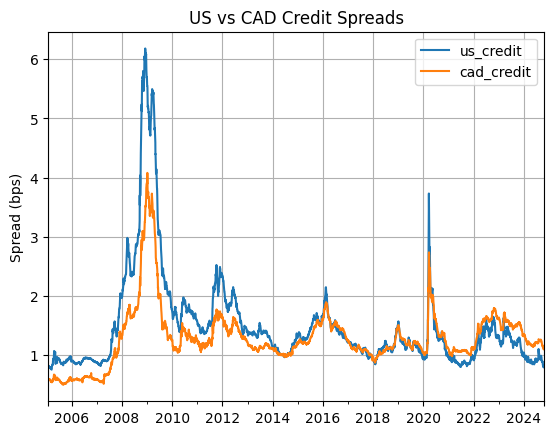

In [4]:

# Get today's date
today = datetime.today().strftime('%Y-%m-%d')

# Initialize fetcher
fetcher = BloombergDataFetcher(
  tickers=['LUACTRUU Index', 'I05510CA Index'],
  fields=['OAS_SOVEREIGN_CURVE'],
  start_date='2005-01-20',
  end_date=today,
  freq='D',
  column_name_format='custom'
)

# Set custom column names
fetcher.set_custom_column_names({
  'LUACTRUU Index_OAS_SOVEREIGN_CURVE': 'us_credit',
  'I05510CA Index_OAS_SOVEREIGN_CURVE': 'cad_credit'
})

# Fetch and process data
credit_spreads = fetcher.run_pipeline(
  handle_missing=True,
  missing_method='ffill',
  max_gap=5,
  align_dates=True,
  calendar='business',
  handle_different_starts=True  # Will use common date range if start dates differ
)

# Basic analysis
print("\nData Analysis:")
print(f"Total trading days: {len(credit_spreads)}")
print("\nSummary Statistics:")
print(credit_spreads.describe().round(3))

# Optional: Plot the spreads
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 8))
credit_spreads.plot()
plt.title('US vs CAD Credit Spreads')
plt.ylabel('Spread (bps)')
plt.grid(True)
plt.show()

# Optional: Save to CSV
# credit_spreads.to_csv('credit_spreads.csv')

In [6]:
# Additional analysis
print("\nCorrelation between spreads:")
print(credit_spreads.corr().round(3))

print("\nSpread Statistics by Year:")
credit_spreads['year'] = credit_spreads.index.year
yearly_stats = credit_spreads.groupby('year').agg(['mean', 'std', 'min', 'max']).round(3)
print(yearly_stats)
del credit_spreads['year']  # Remove the year column after analysis

# Calculate spread differential
credit_spreads['spread_differential'] = credit_spreads['us_credit'] - credit_spreads['cad_credit']
print("\nSpread Differential Statistics:")
print(credit_spreads['spread_differential'].describe().round(3))


Correlation between spreads:
            us_credit  cad_credit
us_credit       1.000       0.893
cad_credit      0.893       1.000

Spread Statistics by Year:
     us_credit                      cad_credit                     
          mean    std    min    max       mean    std    min    max
year                                                               
2005     0.893  0.066  0.758  1.073      0.574  0.039  0.507  0.675
2006     0.905  0.035  0.840  0.963      0.608  0.024  0.543  0.699
2007     1.192  0.370  0.818  2.046      0.832  0.262  0.518  1.401
2008     3.419  1.369  1.985  6.180      2.098  0.704  1.332  3.920
2009     3.406  1.323  1.718  5.548      2.277  0.915  1.253  4.079
2010     1.701  0.134  1.392  1.978      1.254  0.121  1.041  1.544
2011     1.773  0.401  1.358  2.524      1.366  0.230  1.052  1.772
2012     1.778  0.256  1.307  2.341      1.431  0.115  1.224  1.651
2013     1.356  0.070  1.136  1.547      1.134  0.034  1.057  1.224
2014     1.092  0.096  0